# load dataset

In [3]:
from tqdm import trange, tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
dataset = pd.read_csv("Goulburn.csv",parse_dates=["Date"])

In [5]:
dataset.head()

,Date,Conductivity,PH,Turbidity,Temperature
0,2009-07-06 00:00:00+10:00,66.0,NaN,NaN,9.8
1,2009-07-07 00:00:00+10:00,66.0,6.82,9.7,9.6
2,2009-07-08 00:00:00+10:00,67.0,6.58,9.7,9.3
3,2009-07-09 00:00:00+10:00,67.0,6.63,9.3,9.2
4,2009-07-10 00:00:00+10:00,69.0,6.71,9.6,9.3


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4301 entries, 0 to 4300
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype                                
---  ------        --------------  -----                                
 0   Date          4301 non-null   datetime64[ns, pytz.FixedOffset(600)]
 1   Conductivity  4185 non-null   float64                              
 2   PH            3529 non-null   float64                              
 3   Turbidity     3820 non-null   float64                              
 4   Temperature   4156 non-null   float64                              
dtypes: datetime64[ns, pytz.FixedOffset(600)](1), float64(4)
memory usage: 168.1 KB


In [7]:
# set datetime index
dataset.index = dataset.Date.copy()

In [8]:
# drop NaN
dataset.dropna(inplace=True)

In [9]:
# Normalize
dataset['PH_norm'] = (dataset.PH - dataset.PH.mean())/dataset.PH.std()
dataset['Conduct_norm'] = (dataset.Conductivity - dataset.Conductivity.mean())/dataset.Conductivity.std()
dataset['Temp_norm'] = (dataset.Temperature - dataset.Temperature.mean())/dataset.Temperature.std()
dataset['Turb_norm'] = (dataset.Turbidity - dataset.Turbidity.mean())/dataset.Turbidity.std()

In [10]:
dataset.head()

,Date,Conductivity,PH,Turbidity,Temperature,PH_norm,Conduct_norm,Temp_norm,Turb_norm
Date,,,,,,,,,
2009-07-07 00:00:00+10:00,2009-07-07 00:00:00+10:00,66.0,6.82,9.7,9.6,-0.831885,-0.424352,-1.343368,-0.517130
2009-07-08 00:00:00+10:00,2009-07-08 00:00:00+10:00,67.0,6.58,9.7,9.3,-1.676229,-0.390683,-1.410164,-0.517130
2009-07-09 00:00:00+10:00,2009-07-09 00:00:00+10:00,67.0,6.63,9.3,9.2,-1.500324,-0.390683,-1.432429,-0.531325
2009-07-10 00:00:00+10:00,2009-07-10 00:00:00+10:00,69.0,6.71,9.6,9.3,-1.218876,-0.323344,-1.410164,-0.520679
2009-07-11 00:00:00+10:00,2009-07-11 00:00:00+10:00,71.0,6.77,10.0,9.5,-1.007790,-0.256005,-1.365633,-0.506484


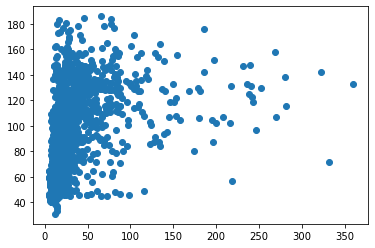

In [11]:
plt.scatter(dataset.Turbidity, dataset.Conductivity)

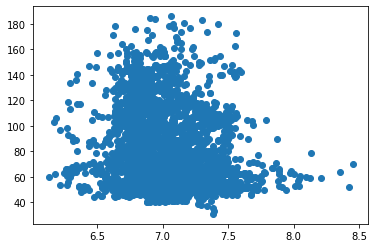

In [12]:
plt.scatter(dataset.PH, dataset.Conductivity)

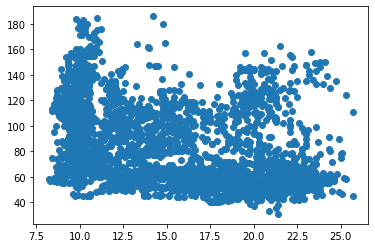

In [13]:
plt.scatter(dataset.Temperature, dataset.Conductivity)

<AxesSubplot:xlabel='Date'>

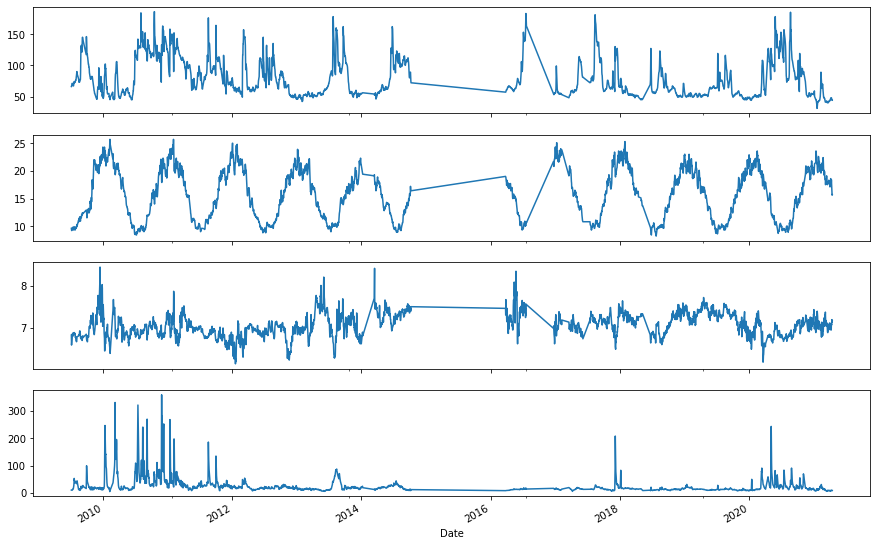

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)
dataset.Conductivity.plot(ax=axes[0])
dataset.Temperature.plot(ax=axes[1])
dataset.PH.plot(ax=axes[2])
dataset.Turbidity.plot(ax=axes[3])

<AxesSubplot:>

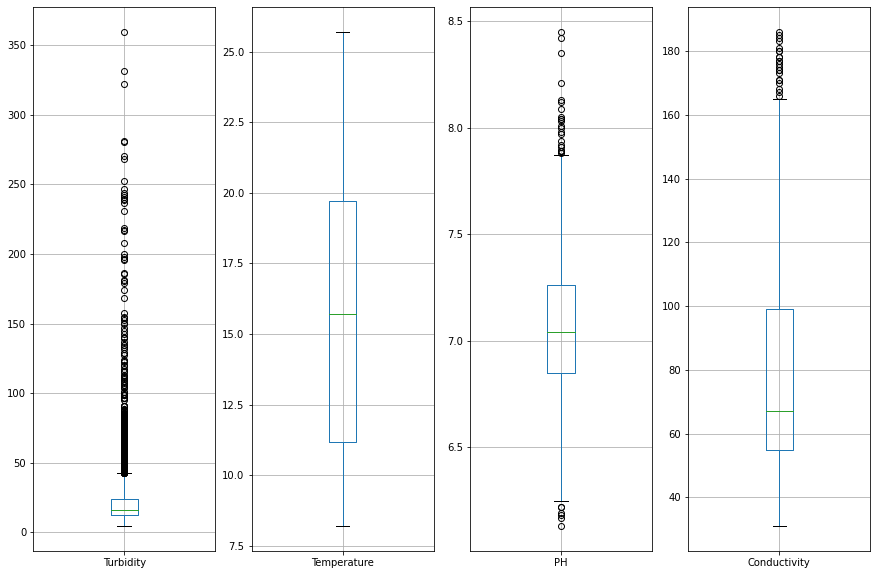

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=4)
fig.set_figheight(10)
fig.set_figwidth(15)
dataset.boxplot(column="Turbidity", ax=axes[0])
dataset.boxplot(column="Temperature", ax=axes[1])
dataset.boxplot(column="PH", ax=axes[2])
dataset.boxplot(column="Conductivity", ax=axes[3])

<AxesSubplot:xlabel='Date'>

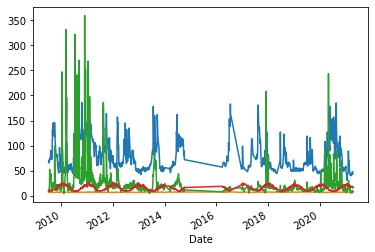

In [16]:
dataset.Conductivity.plot()
dataset.PH.plot()
dataset.Turbidity.plot()
dataset.Temperature.plot()

# split

In [17]:
import torch

In [18]:
X = dataset[["PH_norm", "Temp_norm", "Turb_norm"]]
y = dataset.Conduct_norm

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [21]:
X_train = torch.from_numpy(X_train.to_numpy()).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train.to_numpy()).type(torch.FloatTensor)
X_test = torch.from_numpy(X_test.to_numpy()).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test.to_numpy()).type(torch.FloatTensor)

## prepare data for training

In [22]:
import os
import torch
from torch import nn
import torch.nn.functional as F

In [23]:
from torch.utils.data import Dataset, DataLoader

PyTorch provides DataLoader and Dataset to decouple dataset code from model training code. Dataset stores the samples and their labels. DataLoader runs iterations on a specifed number of samples to enable easy access to samples (Source: Pytorch.org)

In [24]:
class TheDataset(Dataset):
    #initialize the directory for X and y
    def __init__(self, X, y):
        self.X = X
        self.y = y
    #len returns the number of samples
    def __len__(self):
        return self.X.shape[0]
    #getitem loads and returns a sample at a given index idx - also converts the samples into tensor form
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [25]:
train_ds = TheDataset(X_train, y_train)
test_ds = TheDataset(X_test, y_test)

Dataset retrieves dataset one sample at a time. However, when we train our model, we want to pass samples in batch_size then reshuffle data at every epoch to reduce model overfitting 

In [74]:
BATCH_SIZE = 10
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

## build model

In [67]:
baseline_model = torch.nn.Sequential(
    torch.nn.Linear(3, 4),
    torch.nn.Sigmoid(),
    torch.nn.Linear(4, 1)
)

In [68]:
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.RMSprop(baseline_model.parameters(), lr=1e-3)

In [69]:
def train_model(model, loss_fn, optimizer, train_dl):
    total = 0
    sum_loss = 0
    for index, (feats,target) in enumerate(train_dl):
    #to make sure DataLoader passes all data in dataset
        pred = model(feats)
        losses = loss_fn(pred, target)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        batch_size = feats.shape[0]
        total += batch_size
        sum_loss += batch_size*losses.item()
    return sum_loss/total

In [70]:
def train_loop(model, loss_fn, optim, epochs, train_dl):
    t = trange(epochs, desc='Bar desc', leave=True)
    #to show smart progress meter
    for i in t:
        loss = train_model(model, loss_fn, optim, train_dl)
        if i % 10 == 0:
               t.set_description(f"loss = {loss}", refresh=True)

In [71]:
#Print out predicted outputs from train data to calculate RMSE
preds = baseline_model(X_train).detach().numpy().tolist()
preds
df = pd.DataFrame(preds, columns=['preds'])
df['index'] = range(1, len(df) + 1)
df['ytrain'] = y_train
os.chdir("/Users/megannguyen/Desktop/DATA5711")
df.to_csv("5_node.csv", header=True)

In [72]:
#Print out predicted outputs from test data to calculate RMSE
preds_test = baseline_model(X_test).detach().numpy().tolist()
df_test = pd.DataFrame(preds_test, columns=['preds'])
df_test['index'] = range(1, len(df_test) + 1)
df_test['ytest'] = y_test
os.chdir("/Users/megannguyen/Desktop/DATA5711")
df_test.to_csv("5_node_test.csv", header=True)

In [73]:
#Show progress meter that represents loss throughout 100 epochs
train_loop(baseline_model, loss_fn, optimizer, 100, train_loader)

Bar desc:   0%|          | 0/100 [00:00<?, ?it/s]/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
loss = 0.9942127058735002: 100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


- [x] get parameters
- [x] calculate residuals
- [x] bootstrapping residuals
- [x] generate new synthetic datasets from sampled residuals
- [x] estimate parameters for each model trained on each new synthetic dataset
- [x] aggregate all parameters from all models
- [x] Calculate covariance and means of these all parameters
- [x] MCMC from this covariance and means to more sets of parameters
- [x] create models from these set of parameters, validate on test set
- [x] plot uncertainty of output

In [75]:
baseline_model.eval()
#Calculate residuals to prepare for resampling
residuals = y_train - baseline_model(X_train).squeeze()

In [76]:
residuals.shape

torch.Size([2478])

### residual bootstrapping

In [77]:
from sklearn.utils import resample

In [101]:
bootstrap_residuals = []
for i in range(30):
#given the set of residuals we replace and shuffle values within the set
    bootstrap_residual = resample(residuals.detach(), n_samples=residuals.shape[0], replace=True)
    bootstrap_residuals.append(bootstrap_residual)

In [102]:
residuals

tensor([-0.3082, -0.7963, -0.8673,  ..., -0.3732, -0.0252, -1.0037],
       grad_fn=<SubBackward0>)

In [103]:
bootstrap_residuals

[tensor([ 1.7397, -0.1161,  0.4018,  ...,  0.2335, -0.3181, -0.3827]),
 tensor([-0.1778,  1.6728,  1.3401,  ..., -0.0119, -0.5434, -0.8887]),
 tensor([-0.3795,  0.7321,  0.7816,  ..., -1.0423, -0.2848, -0.7264]),
 tensor([ 0.5603, -0.6099, -0.6358,  ...,  0.8664,  0.6428,  1.2386]),
 tensor([-0.4691, -0.5674, -0.4526,  ..., -0.7679, -0.1213, -0.5460]),
 tensor([ 1.0888, -0.5090, -0.5580,  ...,  0.2679, -0.9140,  1.0298]),
 tensor([-0.9686,  0.3291,  1.0975,  ...,  0.0266,  1.2000, -0.4456]),
 tensor([-0.8126, -0.5034, -0.4502,  ..., -0.1084, -0.3920, -0.0564]),
 tensor([ 1.6739,  0.6225,  0.3653,  ..., -0.5950,  1.4447, -0.8387]),
 tensor([-0.4136, -0.3699,  1.4076,  ..., -0.7475, -0.4534, -0.4754]),
 tensor([ 0.8314, -0.7659, -0.4109,  ..., -0.8328, -0.8450,  1.2335]),
 tensor([-1.1258,  0.5476,  2.3767,  ...,  1.0913, -0.0984, -1.1242]),
 tensor([-1.0861, -0.4136, -1.0197,  ..., -0.6121,  1.5662, -0.6270]),
 tensor([-0.4912, -0.8672, -0.9377,  ...,  1.0932, -0.6988, -1.0522]),
 tenso

## generate synthetic dataset

In [104]:
synthetic_datasets = []
for bootstrap_residual in bootstrap_residuals:
    synthetic_y = baseline_model(X_train).squeeze().detach() + bootstrap_residual
    synthetic_datasets.append({"feats": X_train, "target": synthetic_y})

In [108]:
list(baseline_model.parameters())

[Parameter containing:
 tensor([[ 0.6301, -0.0389,  0.1607],
         [ 0.0927,  0.0408,  2.4117],
         [-0.1364,  0.3829, -0.5206],
         [ 0.1611, -0.0980,  0.3588]], requires_grad=True),
 Parameter containing:
 tensor([-0.0384, -0.1644, -0.2154, -0.3830], requires_grad=True),
 Parameter containing:
 tensor([[-0.0416,  0.2292, -0.4901, -0.4441]], requires_grad=True),
 Parameter containing:
 tensor([0.3319], requires_grad=True)]

## train synthetic models

In [109]:
synthetic_models = []
for synthetic_dataset in synthetic_datasets:
    feats = synthetic_dataset["feats"]
    target = synthetic_dataset["target"]
    train_dl = DataLoader(TheDataset(feats, target), batch_size=BATCH_SIZE, shuffle=True)
    model = torch.nn.Sequential(
        torch.nn.Linear(3, 4),
    torch.nn.Sigmoid(),
    torch.nn.Linear(4, 1),
    )
    loss_fn = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.RMSprop(baseline_model.parameters(), lr=1e-3)
    train_loop(model, loss_fn, optimizer, 100, train_dl)
    synthetic_models.append(model)

Bar desc:   0%|          | 0/5 [00:00<?, ?it/s]/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
loss = 0.9517592485642505: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


In [110]:
for synthetic_model in synthetic_models:
    #to make sure the model works for both test and train datasets
    synthetic_model.eval()

In [111]:
list(synthetic_models[0].parameters())

[Parameter containing:
 tensor([[-0.5736,  0.2032,  0.3629],
         [-0.0608,  0.1066, -0.2863],
         [ 0.0927,  0.2244,  0.4928],
         [ 0.3259,  0.5768,  0.1930]], requires_grad=True),
 Parameter containing:
 tensor([-0.1534,  0.4825,  0.1692, -0.4806], requires_grad=True),
 Parameter containing:
 tensor([[-0.1653, -0.1380,  0.2102,  0.1449]], requires_grad=True),
 Parameter containing:
 tensor([-0.3134], requires_grad=True)]

## aggregate parameters from trained synthetic models

In [112]:
#Create a list
parameter_structure = []
for index, module in enumerate(baseline_model.modules()):
#keep parameters of linear layers only
#nelement is the total number of elements in the matrix
    if not isinstance(module, (nn.Sequential, nn.Sigmoid)):
        parameter_structure.append({"index": index-1, "type": "weight", "size": module.weight.size(), "nelement": module.weight.nelement()})
        parameter_structure.append({"index": index-1, "type": "bias", "size": module.bias.size(), "nelement": module.bias.nelement()})

In [113]:
parameter_structure

[{'index': 0, 'type': 'weight', 'size': torch.Size([4, 3]), 'nelement': 12},
 {'index': 0, 'type': 'bias', 'size': torch.Size([4]), 'nelement': 4},
 {'index': 2, 'type': 'weight', 'size': torch.Size([1, 4]), 'nelement': 4},
 {'index': 2, 'type': 'bias', 'size': torch.Size([1]), 'nelement': 1}]

In [114]:
aggregated_params = []
for synthetic_model in synthetic_models:
    #detach parameters into new tensors
    params = [p.detach() for p in synthetic_model.parameters()]
    #cat combines sequence of tensors while reshape(-1) returns a tensor with 1 row only
    concat_params = torch.cat([p.reshape(-1) for p in params])
    aggregated_params.append(concat_params)

In [115]:
aggregated_params[0]

tensor([-0.5736,  0.2032,  0.3629, -0.0608,  0.1066, -0.2863,  0.0927,  0.2244,
         0.4928,  0.3259,  0.5768,  0.1930, -0.1534,  0.4825,  0.1692, -0.4806,
        -0.1653, -0.1380,  0.2102,  0.1449, -0.3134])

In [116]:
#stack all tensors
all_params = torch.vstack(aggregated_params)

## calculate means and covariance matrix of synthetic parameters, create multivariate normal distribution and random sampling 100 sets of parameters

In [117]:
means = np.mean(all_params.numpy(), axis=0)

In [118]:
#convert tensor to numpy array
cov_mat = np.cov(all_params.numpy().T)

In [119]:
from scipy.stats import multivariate_normal

In [120]:
params_dist = multivariate_normal(mean=means, cov=cov_mat)

In [121]:
#create 100 mc simulations from the distribution
mc_params = params_dist.rvs(size=100)

In [122]:
#returns the desired type
mc_params = torch.Tensor(mc_params).type(torch.float32)

In [123]:
mc_params

tensor([[ 0.6234,  0.5533,  0.1059,  ..., -0.1879,  0.3727,  0.2545],
        [ 0.4520, -0.1889, -0.0882,  ...,  0.7203, -0.1854, -0.2005],
        [ 0.5855, -0.2086, -0.2424,  ..., -0.1206, -0.0348,  0.7123],
        ...,
        [ 0.2131, -0.0963,  0.1940,  ...,  0.2625,  0.2767, -0.0157],
        [-0.3271,  0.4304,  0.2429,  ..., -0.2200,  0.4172,  0.0948],
        [ 0.2096, -0.4167, -0.2496,  ..., -0.4081,  0.3771, -0.0705]])

## create models with MC generated sets of params

In [124]:
mc_model = torch.nn.Sequential(
    torch.nn.Linear(3, 4),
    torch.nn.Sigmoid(),
    torch.nn.Linear(4, 1),
)


In [125]:
mc_models = []
for params in mc_params:
    mc_model = torch.nn.Sequential(
        torch.nn.Linear(3, 4),
    torch.nn.Sigmoid(),
    torch.nn.Linear(4, 1),
    )
    # assign params
    index = 0
    for param_struct in parameter_structure:
        layer_index = param_struct["index"]
        param_type = param_struct["type"]
        param_size = param_struct["size"]
        nelement = param_struct["nelement"]
        nelement = index + nelement
        #after we retrieve params for one layer to  put into one row, we retrieve the next params of next layer to put in the same row 
        param = params[index:nelement].reshape(param_size)
        model_layer = mc_model[layer_index]
        setattr(model_layer, param_type, nn.Parameter(param))
        index = nelement
    mc_models.append(mc_model)

In [126]:
len(mc_models)

100

# Uncertainty boxplot

In [127]:
#use test data to predict using MC models
mc_predictions = []
for mc_model in mc_models:
    mc_model.eval()
    mc_prediction = mc_model(X_test).squeeze()
    mc_predictions.append(mc_prediction)

In [128]:
mc_predictions = torch.vstack(mc_predictions)

In [129]:
mc_predictions = mc_predictions.detach().numpy()

In [130]:
mc_predictions = pd.DataFrame(mc_predictions)

In [131]:
mc_predictions

,0,1,2,3,4,5,6,7,8,9,...,816,817,818,819,820,821,822,823,824,825
0,0.318775,0.415375,0.407619,0.424798,0.323500,0.367672,0.358748,0.350310,0.428729,0.365702,...,0.372087,0.389824,0.373808,0.378002,0.358096,0.351400,0.427903,0.396577,0.371269,0.368365
1,0.529576,0.262900,0.218758,0.269263,0.515518,0.280546,0.401179,0.501339,0.270551,0.374258,...,0.372508,0.221583,0.366181,0.316891,0.503030,0.378421,0.300552,0.286656,0.393405,0.379551
2,0.819031,0.897467,0.937208,0.876622,0.816342,0.959161,0.859463,0.781322,0.875129,0.870177,...,0.863661,0.951263,0.867566,0.899266,0.837938,0.903978,0.851681,0.900327,0.846967,0.863685
3,-0.409655,-0.349197,-0.402336,-0.347432,-0.401626,-0.531834,-0.353840,-0.349923,-0.274908,-0.394172,...,-0.353103,-0.437644,-0.334904,-0.418820,-0.024784,-0.478916,-0.238759,-0.391762,-0.336125,-0.342704
4,-0.058708,-0.127555,-0.099529,-0.147734,-0.070237,-0.021853,-0.092269,-0.124739,-0.157654,-0.090172,...,-0.103656,-0.076064,-0.105323,-0.086455,-0.145400,-0.041940,-0.172933,-0.105584,-0.112897,-0.101131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.091040,-0.025244,-0.046448,0.002927,-0.078751,-0.123093,-0.069326,-0.022484,-0.012535,-0.059137,...,-0.055103,-0.069265,-0.059753,-0.057678,-0.178921,-0.101662,-0.005979,-0.040386,-0.048200,-0.062130
96,0.107718,0.102248,0.092068,0.111417,0.110619,0.073639,0.101691,0.128533,0.104138,0.102818,...,0.103688,0.085167,0.101378,0.097972,0.039403,0.089287,0.106858,0.100512,0.107833,0.101953
97,-0.082568,0.026910,-0.056649,0.085801,-0.053449,-0.264248,-0.034754,0.086423,0.093721,-0.039799,...,-0.010411,-0.121720,-0.012233,-0.063231,-0.111108,-0.174345,0.133259,-0.020414,0.017811,-0.018330
98,-0.300838,-0.086939,-0.157415,-0.059812,-0.271430,-0.403028,-0.175931,-0.142398,-0.000399,-0.200246,...,-0.150387,-0.225147,-0.134193,-0.211713,0.191790,-0.347721,0.033774,-0.154232,-0.129598,-0.149136


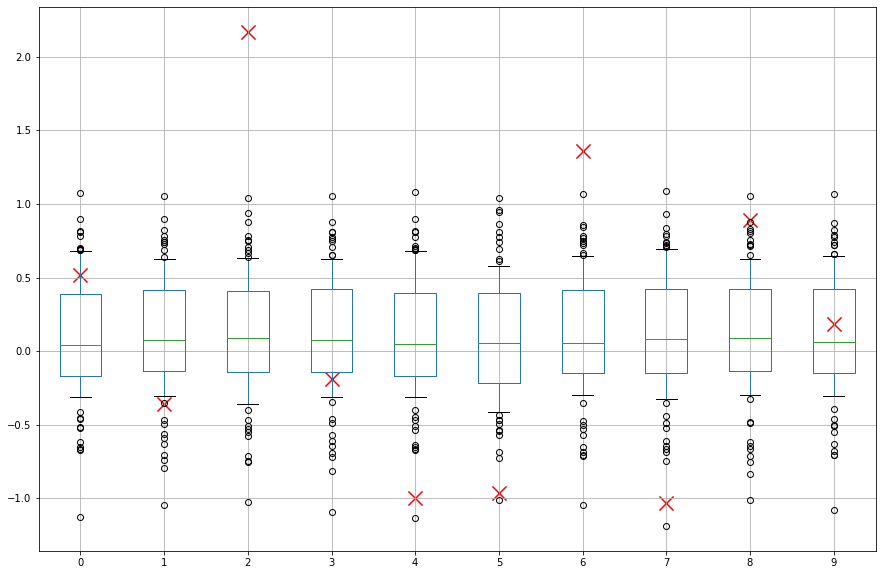

In [132]:
ax = plt.subplot()
ax.figure.set_figwidth(15)
ax.figure.set_figheight(10)
#plot 10th-90th percentile of the first 10 values in test data
mc_predictions.boxplot(figsize=(20, 20), column=list(range(10)), ax=ax, whis=(10, 90))
ax.scatter(range(1,11), y_test[:10], marker="x", c="r", s=200)